# 批量规范化

从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

创建一个正确的`BatchNorm`层

In [2]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

应用`BatchNorm`
于LeNet模型

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

在Fashion-MNIST数据集上训练网络

loss 0.268, train acc 0.900, test acc 0.890
48985.5 examples/sec on cuda:0


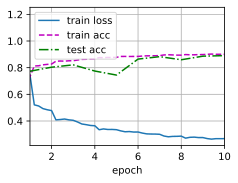

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数`gamma`和偏移参数`beta`

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.0393, 0.8847, 3.2372, 3.0698, 2.9021, 3.9040], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-1.5437, -1.2781, -0.6159, -2.1415,  1.9957, -3.8904], device='cuda:0',
        grad_fn=<ViewBackward0>))

简明实现

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

使用相同超参数来训练模型

loss 0.266, train acc 0.901, test acc 0.808
83502.3 examples/sec on cuda:0


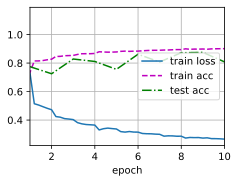

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 练习

3. 我们是否需要在每个层中进行批量规范化？尝试一下？

loss 0.352, train acc 0.871, test acc 0.829
97106.6 examples/sec on cuda:0


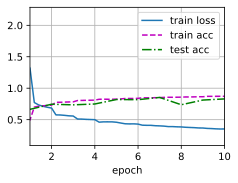

In [8]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.290, train acc 0.891, test acc 0.603
96753.5 examples/sec on cuda:0


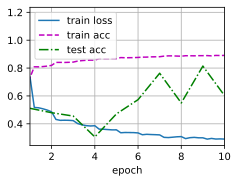

In [9]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
net[8].weight, net[8].bias

(Parameter containing:
 tensor([1.2421, 1.3136, 1.1429, 1.5533, 0.9639, 1.1405, 1.0840, 1.4240, 1.3422,
         1.2021, 1.1707, 1.0005, 1.0959, 0.9705, 1.3642, 1.0499, 1.1294, 1.0986,
         1.1773, 1.2379, 1.2748, 1.3428, 1.0442, 1.1673, 1.7466, 1.5707, 1.7556,
         1.3635, 0.9612, 0.9942, 1.0059, 1.1395, 1.6404, 1.2446, 0.9542, 1.1372,
         1.0469, 1.5937, 1.3889, 1.3844, 0.9828, 1.0906, 1.2381, 1.1434, 0.9972,
         1.1865, 1.9154, 1.3873, 0.9745, 1.0196, 1.6443, 1.0676, 0.9728, 1.1875,
         1.3026, 1.1317, 0.9651, 1.1982, 0.9355, 0.8373, 1.2259, 0.9603, 1.9066,
         1.2733, 1.0388, 1.4587, 1.1987, 1.8485, 1.1757, 1.0530, 1.4705, 1.2647,
         1.3037, 1.1682, 1.0556, 1.0637, 1.6869, 1.0931, 0.9597, 0.9908, 1.0568,
         1.1638, 1.0807, 1.9713, 1.3802, 1.2403, 1.4008, 1.1499, 1.1201, 1.6665,
         2.1749, 1.4933, 1.1104, 1.3926, 1.1694, 1.2003, 1.1021, 1.3241, 1.6704,
         1.3126, 1.0088, 1.4766, 1.2710, 1.1345, 1.7919, 1.1195, 1.0631, 1.2129,
     

In [20]:
net[11].weight, net[11].bias

(Parameter containing:
 tensor([1.6781, 2.3550, 1.8730, 1.9045, 1.6919, 1.9925, 1.4938, 1.5059, 2.0214,
         1.3840, 1.7557, 1.5841, 1.6467, 1.5986, 1.4871, 1.5800, 1.5270, 1.5590,
         1.7435, 1.6836, 2.0077, 1.4339, 1.7235, 1.7417, 1.8451, 1.9641, 1.6916,
         1.5229, 1.5457, 1.9504, 1.8442, 1.8596, 1.7421, 1.5415, 1.8913, 1.3680,
         1.9470, 1.5358, 1.5790, 2.1260, 1.7652, 1.6637, 2.1098, 1.6008, 1.6740,
         1.8330, 1.7801, 1.6531, 1.5169, 1.5997, 1.6102, 1.6221, 1.7068, 1.5164,
         1.9765, 1.6870, 1.7516, 2.1036, 1.6724, 1.8040, 1.6840, 1.6184, 1.8020,
         2.3531, 2.0545, 1.6631, 1.7824, 1.8686, 1.7457, 1.4165, 1.8891, 1.9080,
         1.5334, 1.6113, 1.6769, 1.8134, 1.8042, 1.3870, 1.5507, 1.8435, 2.0079,
         1.6382, 1.6388, 1.6270], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.5322, -0.3826, -0.3987, -0.4069, -0.1914, -0.5079, -0.6871, -0.3796,
         -0.3770, -0.3786, -0.5837, -0.2480, -0.3422, -0.2541, -0.3547, 

结论：卷积层后面的BN层不可删除，全链接层后的BN层可以删除

4. 可以通过批量规范化来替换暂退法吗？行为会如何改变？

不可以，见下面 `VGG-11 + BN` 的测试，解决不了过拟合的问题

### AlexNet + BN

loss 0.216, train acc 0.922, test acc 0.835
937.3 examples/sec on cuda:0


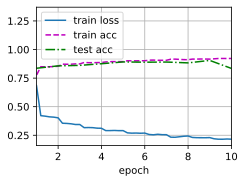

In [22]:
net = nn.Sequential(
  nn.Conv2d(1, 192, kernel_size=7, padding=3), nn.BatchNorm2d(192), nn.ReLU(),
  nn.MaxPool2d(2, stride=1),
  nn.Conv2d(192, 256, kernel_size=5, padding=2), nn.BatchNorm2d(256), nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
  nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
  nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(256*6*6, 8192), nn.ReLU(), nn.Dropout(),
  nn.Linear(8192, 8192), nn.ReLU(), nn.Dropout(),
  nn.Linear(8192, 10)
)

lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [2]:
import time

In [26]:
net = nn.Sequential(
  nn.Conv2d(1, 192, kernel_size=7, padding=3), nn.BatchNorm2d(192), nn.ReLU(),
  nn.MaxPool2d(2, stride=1),
  nn.Conv2d(192, 256, kernel_size=5, padding=2), nn.BatchNorm2d(256), nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
  nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
  nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(256*6*6, 8192), nn.BatchNorm1d(8192), nn.ReLU(), nn.Dropout(),
  nn.Linear(8192, 8192), nn.BatchNorm1d(8192), nn.ReLU(), nn.Dropout(),
  nn.Linear(8192, 10)
)

lr, num_epochs = 0.01, 10

loss 0.208, train acc 0.924, test acc 0.910
928.8 examples/sec on cuda:0
CPU times: user 11min 26s, sys: 4.26 s, total: 11min 30s
Wall time: 11min 37s


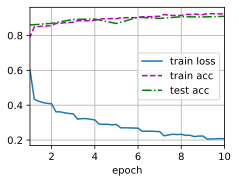

In [27]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### VGG-11 + BN

In [28]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.BatchNorm1d(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.BatchNorm1d(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.100, train acc 0.964, test acc 0.936
878.9 examples/sec on cuda:0
CPU times: user 12min 2s, sys: 23.9 s, total: 12min 26s
Wall time: 12min 29s


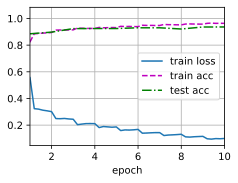

In [29]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [4]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.BatchNorm1d(4096), nn.ReLU(),
        nn.Linear(4096, 4096), nn.BatchNorm1d(4096), nn.ReLU(),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.002, train acc 1.000, test acc 0.938
786.4 examples/sec on cuda:0
CPU times: user 13min 27s, sys: 23.9 s, total: 13min 51s
Wall time: 13min 54s


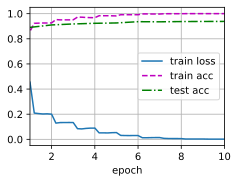

In [5]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

直接去掉 Dropout 后，完全过拟合

In [6]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096),  nn.ReLU(), nn.BatchNorm1d(4096),
        nn.Linear(4096, 4096), nn.ReLU(), nn.BatchNorm1d(4096),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.015, train acc 0.996, test acc 0.936
881.6 examples/sec on cuda:0
CPU times: user 12min, sys: 24 s, total: 12min 24s
Wall time: 12min 31s


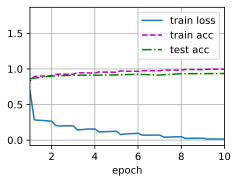

In [7]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

用 BN 直接替换 Dropout，也会导致严重过拟合

In [8]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096),  nn.ReLU(), nn.BatchNorm1d(4096), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.BatchNorm1d(4096), nn.Dropout(0.5),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.146, train acc 0.948, test acc 0.917
882.0 examples/sec on cuda:0
CPU times: user 12min, sys: 23.4 s, total: 12min 23s
Wall time: 12min 26s


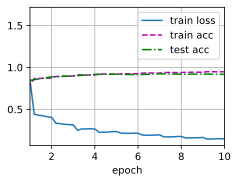

In [9]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

BN 层放在 ReLU 后面，效果不如放在前面好。

### GoogLeNet + BN

In [3]:
torch.set_float32_matmul_precision("medium")

In [31]:
from torch.nn import functional as F

In [32]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   nn.LazyBatchNorm2d(),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.LazyBatchNorm2d(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   nn.LazyBatchNorm2d(),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   nn.LazyBatchNorm2d(),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   nn.LazyBatchNorm2d(),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   nn.LazyBatchNorm2d(),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.LazyBatchNorm2d(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   nn.LazyBatchNorm2d(),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.LazyBatchNorm2d(),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

/usr/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.122, train acc 0.954, test acc 0.920
2011.1 examples/sec on cuda:0
CPU times: user 5min 6s, sys: 23.1 s, total: 5min 29s
Wall time: 5min 33s


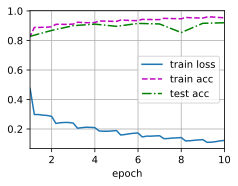

In [33]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())